In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import sqlite3
import json

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


## Read in data

read in station name

In [4]:
df = pd.read_json('../ML_data_DJF.json')

## clean data

In [5]:
from datetime import datetime
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]

df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

#stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']
#stnlist=['東沙島浮標']
#stnlist=['新竹浮標','臺東外洋浮標','東沙島浮標','馬祖浮標']
stnlist=['臺東外洋浮標','東沙島浮標','馬祖浮標']

dataset = dataset[dataset['STN'].isin(stnlist)]
dataset = dataset.dropna()

In [6]:
dataset.isna().sum()

STN         0
ST          0
DATETIME    0
H           0
Temp        0
P           0
Vm          0
Vmsat       0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [7]:
dataset = dataset.dropna()
dataset.tail()

,STN,ST,DATETIME,H,Temp,P,Vm,Vmsat
877101,馬祖浮標,C6W08,2018-12-30 20:00:00,3.52,16.3,1030.6,14.0,16.348304
877107,馬祖浮標,C6W08,2018-12-31 02:00:00,2.73,16.1,1030.4,12.4,14.287296
877113,馬祖浮標,C6W08,2018-12-31 08:00:00,3.51,16.1,1032.7,12.9,14.614159
877119,馬祖浮標,C6W08,2018-12-31 14:00:00,3.10,15.5,1029.3,12.5,14.517667
877125,馬祖浮標,C6W08,2018-12-31 20:00:00,3.33,15.8,1031.2,12.9,13.381326


<Figure size 3200x1600 with 0 Axes>

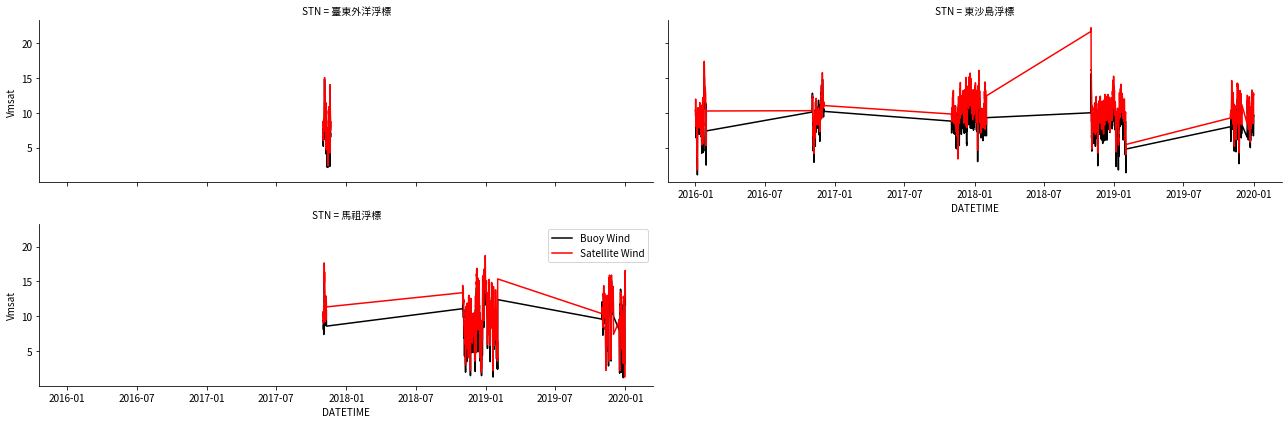

In [8]:
%matplotlib inline
plt.figure(figsize=(16,8),dpi=200)
g = sns.FacetGrid(dataset, col="STN", col_wrap=2, height=3, aspect=3)
g.map(sns.lineplot, 'DATETIME','Vm',color='k')
g.map(sns.lineplot, 'DATETIME','Vmsat',color='r')
plt.legend(labels=['Buoy Wind','Satellite Wind'])

In [9]:
dataset.pop('DATETIME')
dataset.pop('ST')
dataset.pop('STN')

154431    臺東外洋浮標
154437    臺東外洋浮標
154443    臺東外洋浮標
154449    臺東外洋浮標
154455    臺東外洋浮標
           ...  
877101      馬祖浮標
877107      馬祖浮標
877113      馬祖浮標
877119      馬祖浮標
877125      馬祖浮標
Name: STN, Length: 1685, dtype: object

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

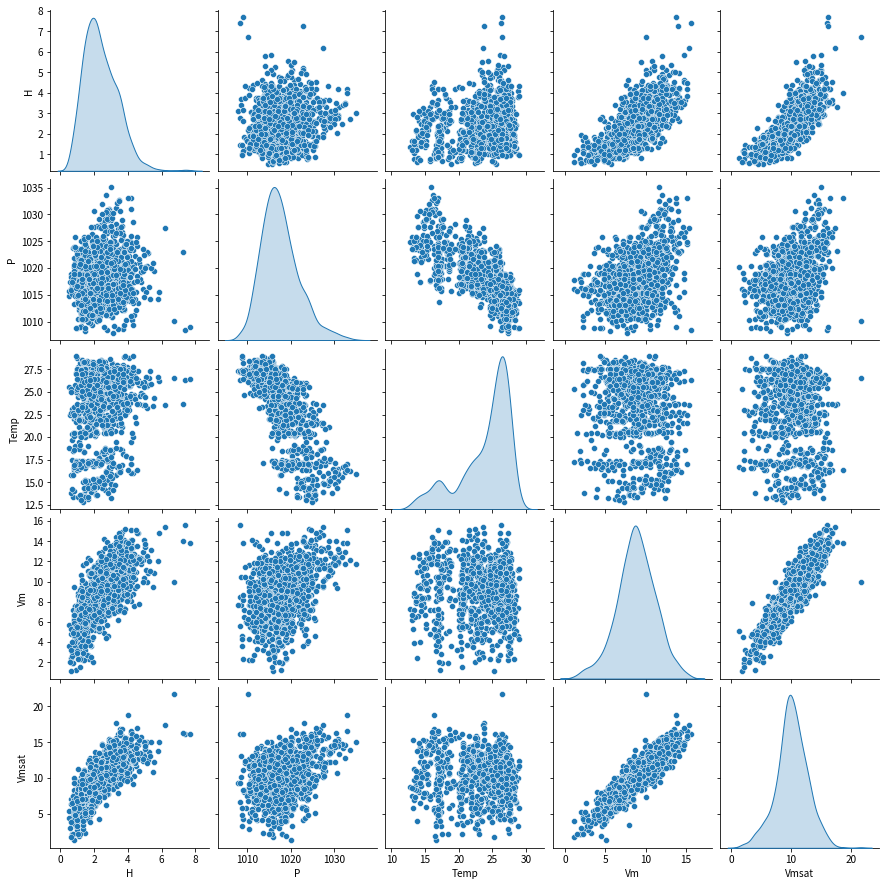

In [11]:
sns.pairplot(train_dataset[['H', 'P', 'Temp', 'Vm','Vmsat']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
H,1348.0,2.412945,0.996230,0.560000,1.680000,2.25500,3.060000,7.680000
Temp,1348.0,23.958605,3.736029,12.800000,22.100000,25.40000,26.700000,29.000000
P,1348.0,1017.600964,4.366773,1007.900000,1014.575000,1017.10000,1020.000000,1035.200000
Vm,1348.0,8.823516,2.398936,1.100000,7.300000,8.80000,10.400000,15.600000
Vmsat,1348.0,10.139725,2.639663,1.293657,8.672546,10.14273,11.761087,21.665361


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('H')
test_labels = test_features.pop('H')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
H,2.412945,0.996230
Temp,23.958605,3.736029
P,1017.600964,4.366773
Vm,8.823516,2.398936
Vmsat,10.139725,2.639663


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable.

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [15]:
normalizer = preprocessing.Normalization(axis=-1)

Then `.adapt()` it to the data:

In [16]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [17]:
print(normalizer.mean.numpy())

[  23.959 1017.601    8.824   10.14 ]


When the layer is called it returns the input data, with each feature independently normalized:

In [18]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  25.8  1012.      8.3    10.18]]

Normalized: [[ 0.49 -1.28 -0.22  0.02]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `H` from `Vmsat`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `Vmsat`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [19]:
Vm = np.array(train_features['Vm'])

Vm_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
Vm_normalizer.adapt(Vm)

Build the sequential model:

In [20]:
Vm_model = tf.keras.Sequential([
    Vm_normalizer,
    layers.Dense(units=1)
])

Vm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `H` from `Vms`.

Run the untrained model on the first 10 Vm values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [21]:
Vm_model.predict(Vm[:10])

array([[-0.043],
       [ 0.305],
       [ 0.073],
       [ 0.197],
       [-0.359],
       [-0.574],
       [-0.118],
       [-0.126],
       [-0.002],
       [-0.01 ]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [22]:
Vm_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [23]:
%%time
history = Vm_model.fit(
    train_features['Vm'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 49.8 s, sys: 5min 55s, total: 6min 45s
Wall time: 12.4 s


Visualize the model's training progress using the stats stored in the `history` object.

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.578995,0.580492,95
96,0.561454,0.574418,96
97,0.571205,0.578691,97
98,0.565288,0.571304,98
99,0.564696,0.563956,99


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [H]')
  plt.legend()
  plt.grid(True)

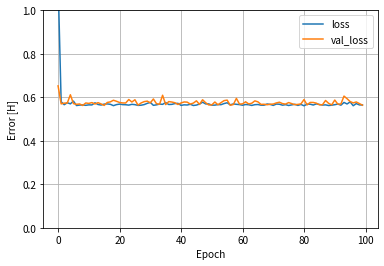

In [26]:
plot_loss(history)

Collect the results on the test set, for later:

In [27]:
test_results = {}

test_results['Vm_model'] = Vm_model.evaluate(
    test_features['Vm'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [28]:
x = tf.linspace(0.0, 20, 251)
y = Vm_model.predict(x)

In [29]:
def plot_Vm(x, y):
  plt.scatter(train_features['Vm'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Vm')
  plt.ylabel('H')
  plt.legend()

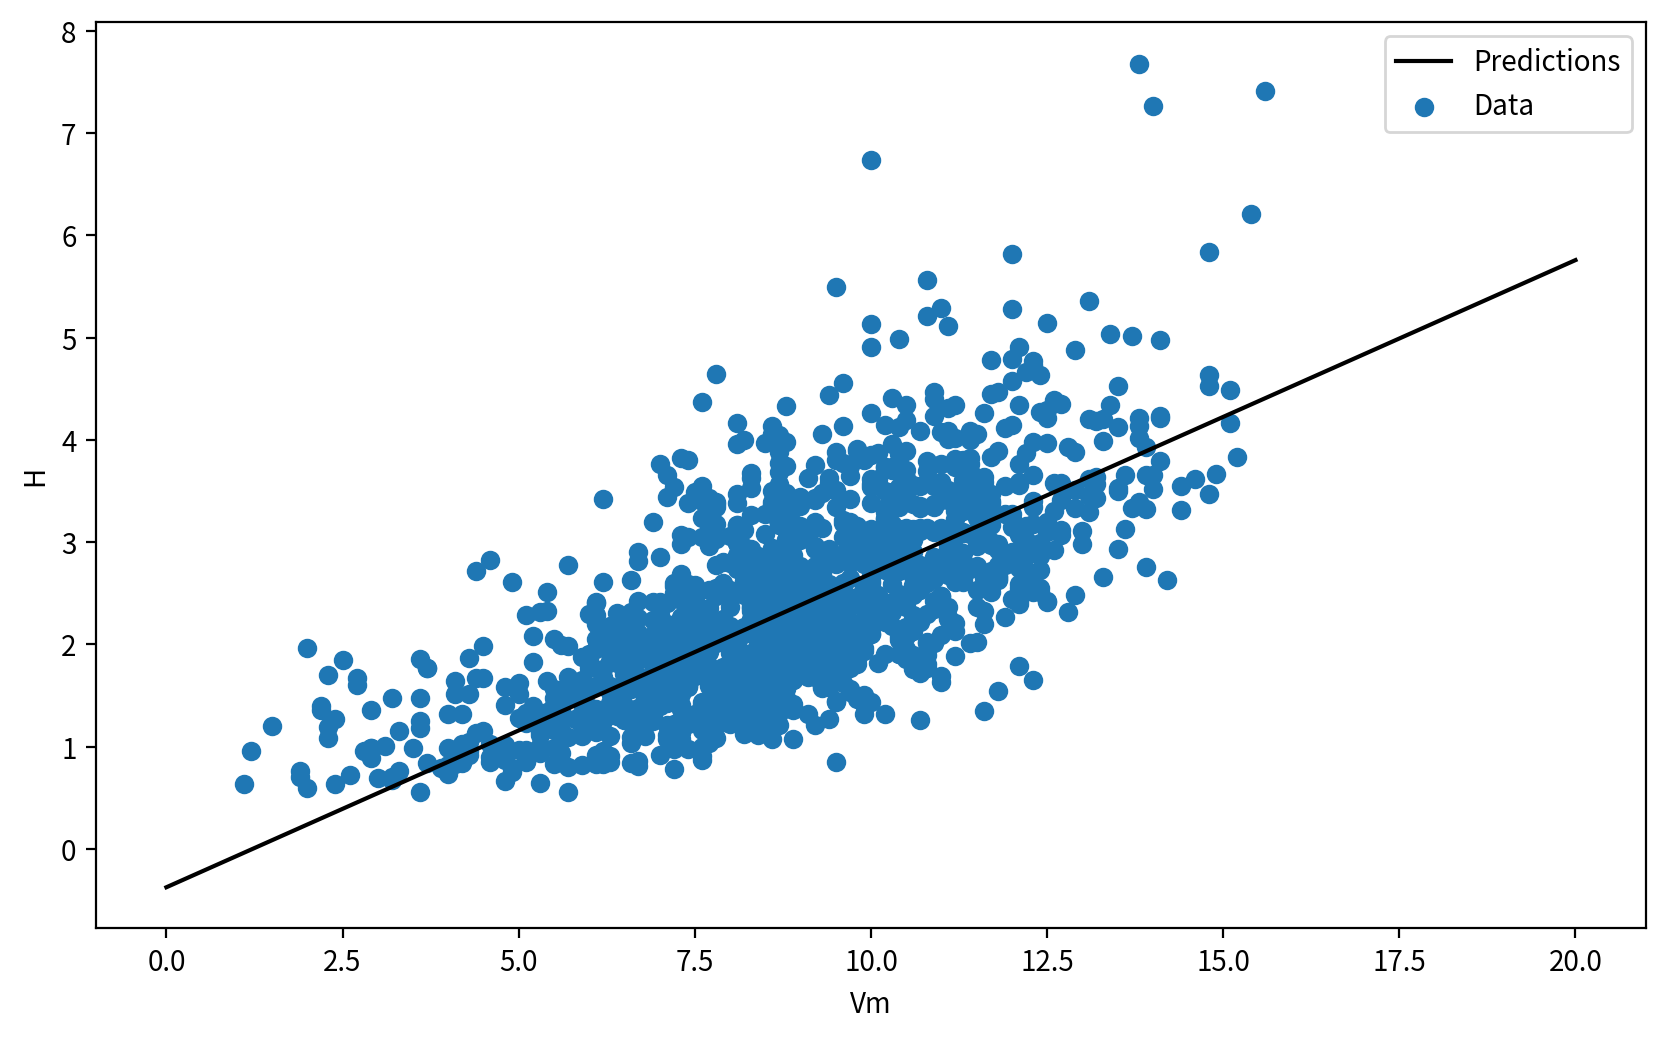

In [30]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vm(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [32]:
linear_model.predict(train_features[:10])

array([[-1.447],
       [ 1.309],
       [-0.821],
       [-0.225],
       [-2.086],
       [-1.311],
       [-0.884],
       [-1.729],
       [-0.849],
       [-0.879]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(4,1)`.

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[-0.314],
       [ 0.829],
       [ 1.025],
       [-0.343]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `Vmsat` model:

In [34]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1min 8s, sys: 8min 50s, total: 9min 59s
Wall time: 17.5 s


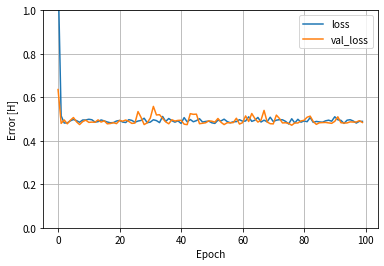

In [36]:
plot_loss(history)

In [37]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [38]:
x = tf.linspace(0.0, 50, 251)
y = linear_model.predict(pd.DataFrame(x))

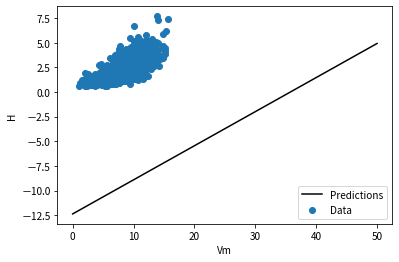

In [39]:
plot_Vm(x,y)

In [40]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.584719
linear_model,0.466554


## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [41]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Vmsat"

In [42]:
dnn_Vm_model = build_and_compile_model(Vm_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [43]:
dnn_Vm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [44]:
%%time
history = dnn_Vm_model.fit(
    train_features['Vm'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 1min 29s, sys: 11min 12s, total: 12min 41s
Wall time: 22.2 s


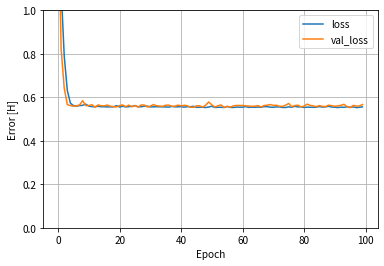

In [45]:
plot_loss(history)

In [46]:
x = tf.linspace(0.0, 20, 251)
y = dnn_Vm_model.predict(x)

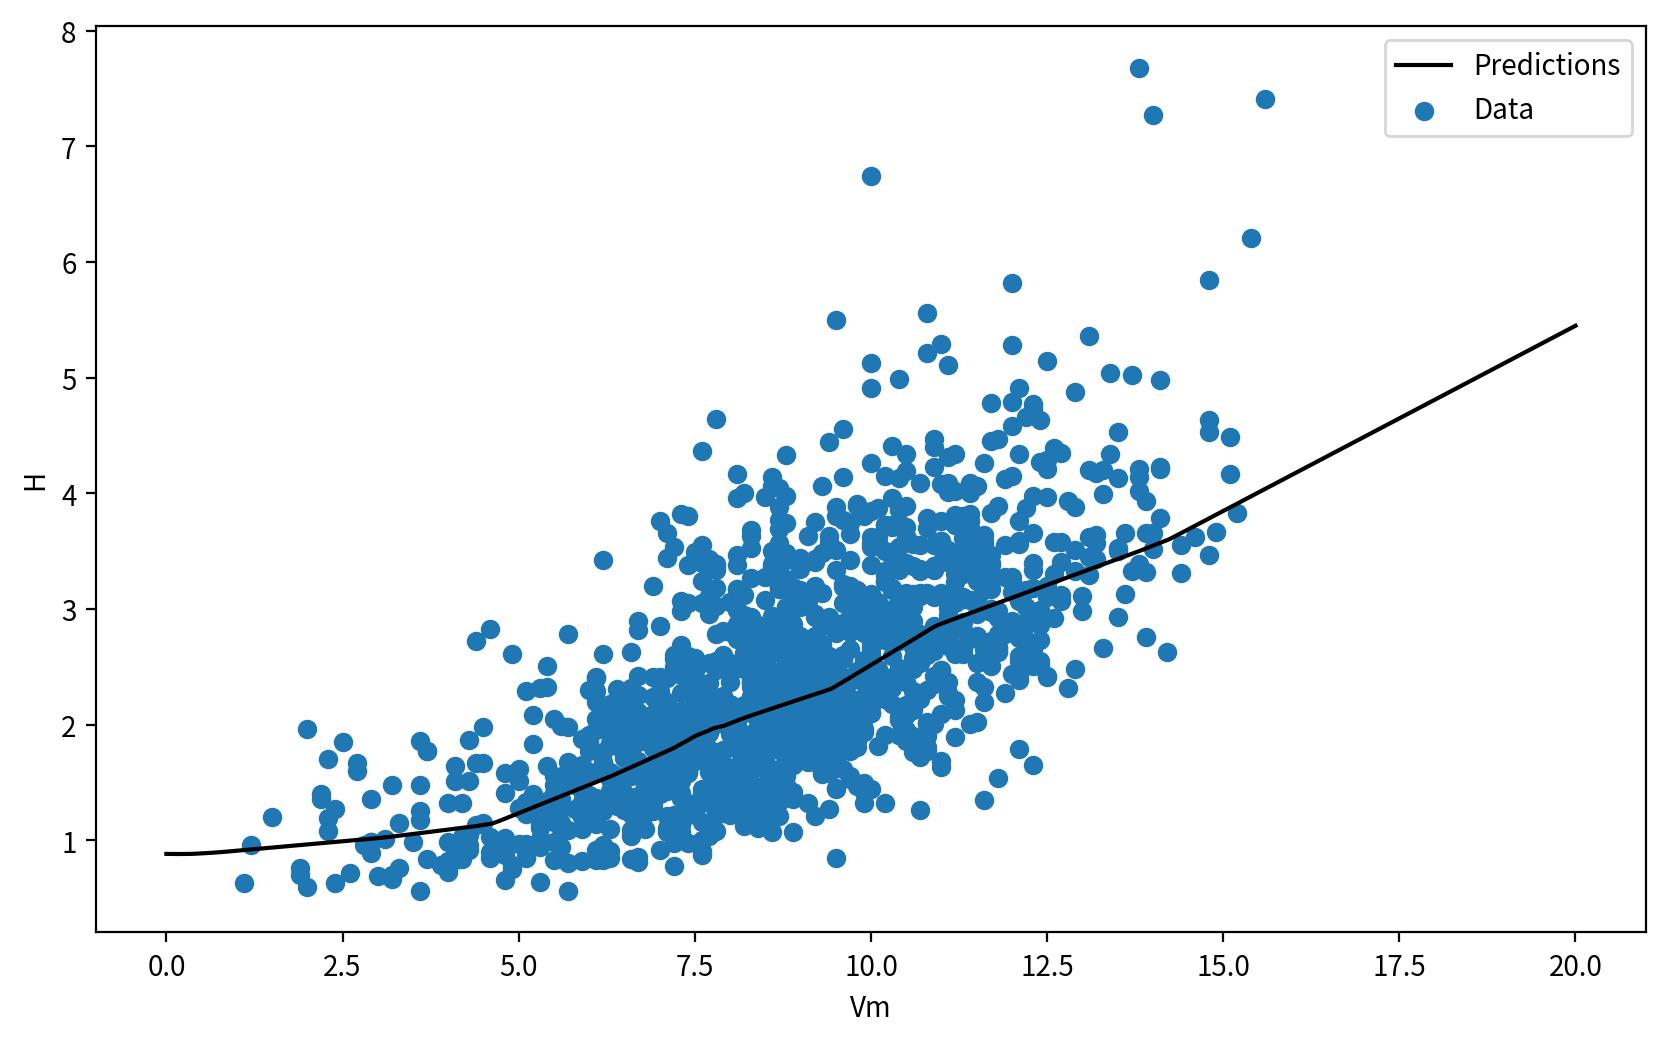

In [47]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vm(x,y)

In [48]:
test_results['dnn_Vm_model'] = dnn_Vm_model.evaluate(
    test_features['Vm'], test_labels,
    verbose=0)

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.584719
linear_model,0.466554
dnn_Vm_model,0.555394


### Full model

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [51]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 1min 37s, sys: 12min 19s, total: 13min 57s
Wall time: 24.5 s


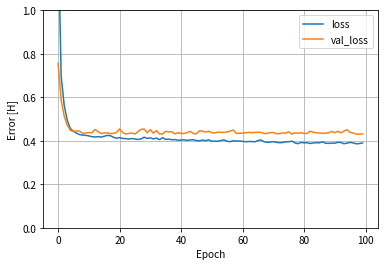

In [52]:
plot_loss(history)

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.584719
linear_model,0.466554
dnn_Vm_model,0.555394
dnn_model,0.403210


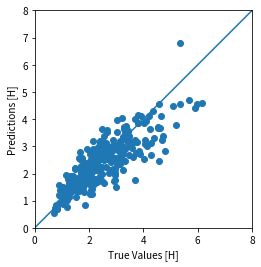

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


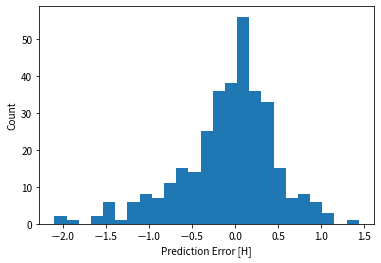

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')

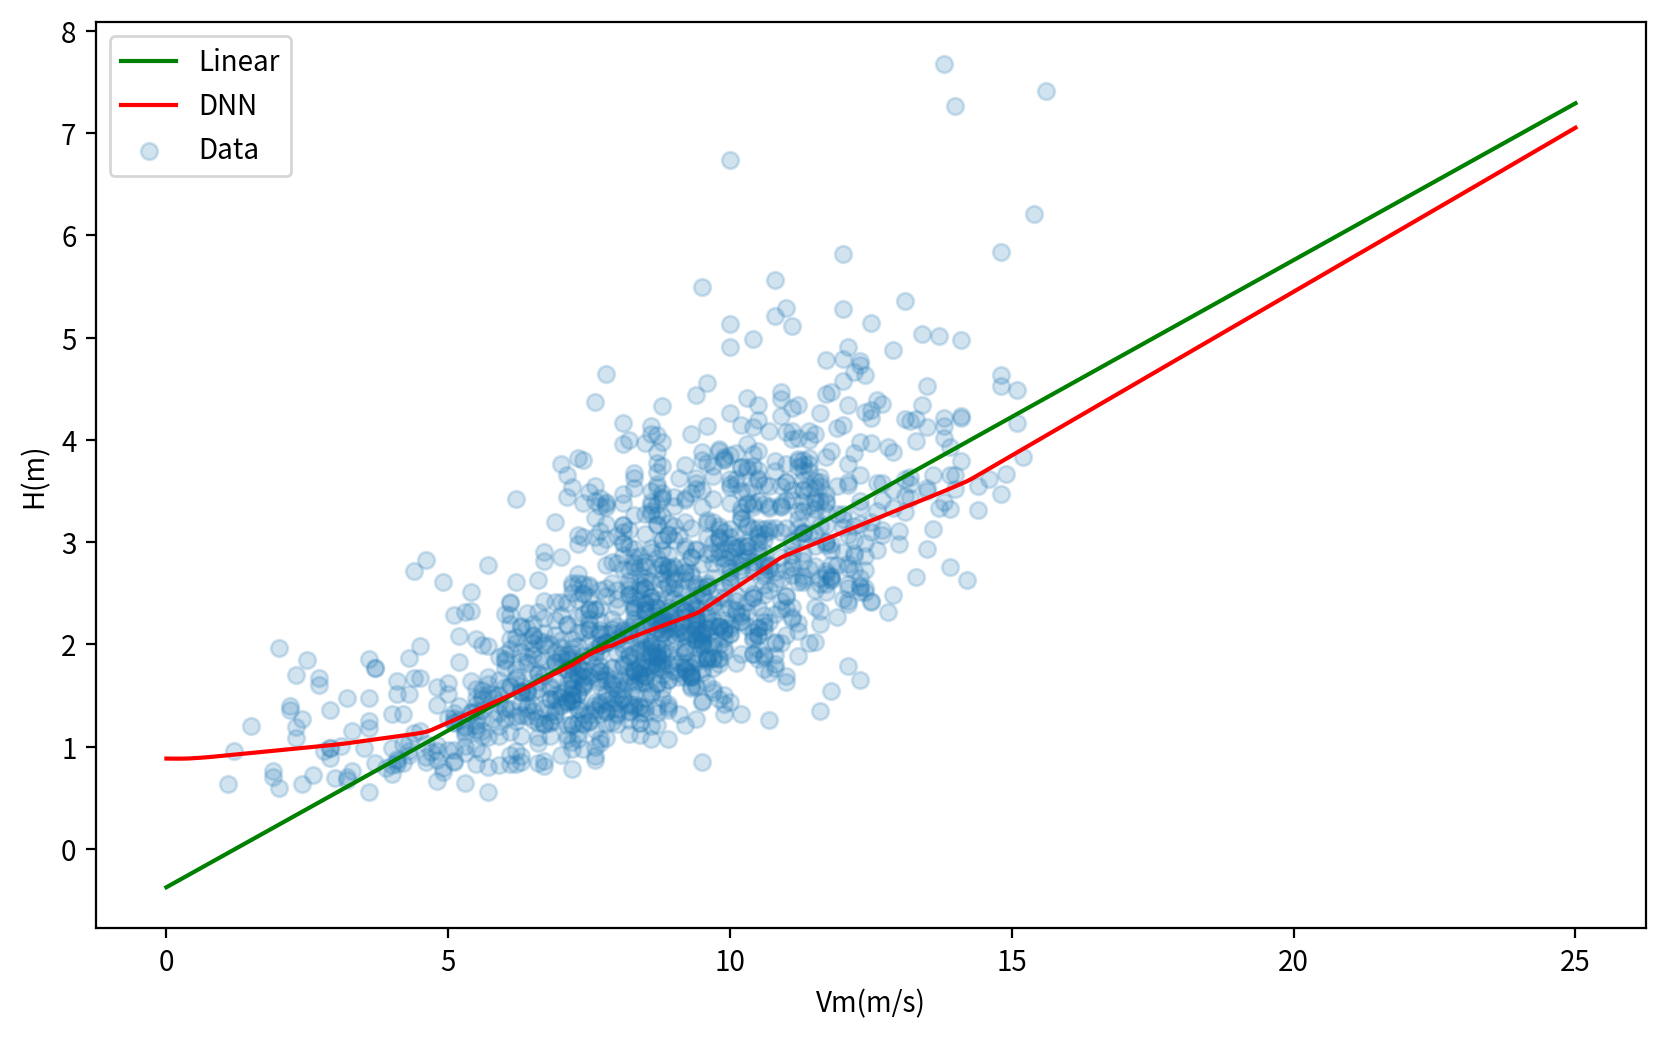

In [57]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
#y1 = dnn_model.predict(x)
y2 = dnn_Vm_model.predict(x)
y4 = Vm_model.predict(x)

plt.scatter(train_features['Vm'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
#plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.xlabel('Vm(m/s)')
plt.ylabel('H(m)')
plt.legend()

In [58]:
!mkdir -p saved_model

In [59]:
linear_model.save('saved_model/Vm_H_linear_model_DJF')
Vm_model.save(    'saved_model/Vm_H_Vm_model_DJF')
dnn_model.save(   'saved_model/Vm_H_dnn_model_DJF')
dnn_Vm_model.save('saved_model/Vm_H_dnn_Vm_model_DJF')

INFO:tensorflow:Assets written to: saved_model/Vm_H_linear_model_DJF/assets
INFO:tensorflow:Assets written to: saved_model/Vm_H_Vm_model_DJF/assets
INFO:tensorflow:Assets written to: saved_model/Vm_H_dnn_model_DJF/assets
INFO:tensorflow:Assets written to: saved_model/Vm_H_dnn_Vm_model_DJF/assets


# RNN

In [60]:
def build_and_compile_model_RNN(Norm):
  model = keras.Sequential([
      Norm,
      layers.SimpleRNN(64,  unroll=False, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [61]:
def build_and_compile_model_LSTM(Norm):
  model = keras.Sequential([
      Norm,
      layers.LSTM(64, input_shape=(1,1), activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [62]:
Vm_normalizer = preprocessing.Normalization(input_shape=[1,1], axis=None)
Vm_normalizer.adapt(Vm)

In [63]:
rnn_Vm_model = build_and_compile_model_RNN(Vm_normalizer)
#rnn_Vm_model = build_and_compile_model_LSTM(Vmsat_normalizer)

In [64]:
rnn_Vm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1, 1)              3         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,292
Trainable params: 4,289
Non-trainable params: 3
_________________________________________________________________


In [65]:
train_features['Vm'],train_labels

(154635     8.3
 160236    12.5
 772437     9.7
 862898    11.2
 869583     4.5
           ... 
 773200     9.2
 780292     8.5
 862697     9.2
 870354    10.8
 780821    12.5
 Name: Vm, Length: 1348, dtype: float64,
 154635    2.93
 160236    5.14
 772437    3.20
 862898    3.05
 869583    1.67
           ... 
 773200    1.93
 780292    1.33
 862697    1.75
 870354    2.71
 780821    2.41
 Name: H, Length: 1348, dtype: float64)

In [66]:
%%time
history = rnn_Vm_model.fit(
    train_features['Vm'], train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
34/34 [==============================] - 2s 17ms/step - loss: 2.0990 - val_loss: 1.7714
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 1.6700 - val_loss: 1.3953
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 1.3026 - val_loss: 0.9947
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 0.9457 - val_loss: 0.7196
Epoch 5/100
34/34 [==============================] - 0s 6ms/step - loss: 0.7503 - val_loss: 0.6189
Epoch 6/100
34/34 [==============================] - 0s 7ms/step - loss: 0.6566 - val_loss: 0.5807
Epoch 7/100
34/34 [==============================] - 0s 7ms/step - loss: 0.6140 - val_loss: 0.5651
Epoch 8/100
34/34 [==============================] - 0s 7ms/step - loss: 0.5847 - val_loss: 0.5541
Epoch 9/100
34/34 [==============================] - 0s 7ms/step - loss: 0.5933 - val_loss: 0.5510
Epoch 10/100
34/34 [==============================] - 0s 7ms/step - loss: 0.5683 - val_loss: 0.5515
Epoch 11

Epoch 83/100
34/34 [==============================] - 0s 8ms/step - loss: 0.5361 - val_loss: 0.5647
Epoch 84/100
34/34 [==============================] - 0s 9ms/step - loss: 0.5547 - val_loss: 0.5567
Epoch 85/100
34/34 [==============================] - 0s 9ms/step - loss: 0.5704 - val_loss: 0.5620
Epoch 86/100
34/34 [==============================] - 0s 10ms/step - loss: 0.5335 - val_loss: 0.5572
Epoch 87/100
34/34 [==============================] - 0s 7ms/step - loss: 0.5680 - val_loss: 0.5593
Epoch 88/100
34/34 [==============================] - 0s 10ms/step - loss: 0.5443 - val_loss: 0.5617
Epoch 89/100
34/34 [==============================] - 0s 8ms/step - loss: 0.5689 - val_loss: 0.5569
Epoch 90/100
34/34 [==============================] - 0s 8ms/step - loss: 0.5411 - val_loss: 0.5608
Epoch 91/100
34/34 [==============================] - 0s 8ms/step - loss: 0.5403 - val_loss: 0.5575
Epoch 92/100
34/34 [==============================] - 0s 8ms/step - loss: 0.5452 - val_loss: 0.557

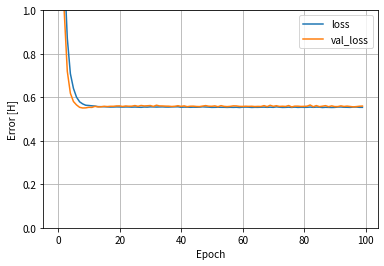

In [67]:
plot_loss(history)

In [68]:
test_results['rnn_Vm_model'] = rnn_Vm_model.evaluate(
    test_features['Vm'], test_labels,
    verbose=0)

In [69]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.584719
linear_model,0.466554
dnn_Vm_model,0.555394
dnn_model,0.403210
rnn_Vm_model,0.554204


### Multi-variable 

In [70]:
normalizer = preprocessing.Normalization(input_shape=[4,1], axis=None)
normalizer.adapt(np.array(train_features))

In [71]:
rnn_model = build_and_compile_model_RNN(normalizer)
rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 4, 1)              3         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,292
Trainable params: 4,289
Non-trainable params: 3
_________________________________________________________________


In [72]:
%%time
history = rnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 15ms/step - loss: 2.3338 - val_loss: 0.9384
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 0.8328 - val_loss: 0.7823
Epoch 3/100
34/34 [==============================] - 0s 9ms/step - loss: 0.7822 - val_loss: 0.7793
Epoch 4/100
34/34 [==============================] - 0s 10ms/step - loss: 0.7770 - val_loss: 0.7799
Epoch 5/100
34/34 [==============================] - 0s 9ms/step - loss: 0.8042 - val_loss: 0.7824
Epoch 6/100
34/34 [==============================] - 0s 9ms/step - loss: 0.7996 - val_loss: 0.7820
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 0.7781 - val_loss: 0.7795
Epoch 8/100
34/34 [==============================] - 0s 12ms/step - loss: 0.7779 - val_loss: 0.7839
Epoch 9/100
34/34 [==============================] - 0s 12ms/step - loss: 0.8015 - val_loss: 0.7790
Epoch 10/100
34/34 [==============================] - 0s 11ms/step - loss: 0.8074 - val_loss: 0.7796
Epoc

34/34 [==============================] - 1s 22ms/step - loss: 0.7691 - val_loss: 0.7918
Epoch 83/100
34/34 [==============================] - 1s 24ms/step - loss: 0.8117 - val_loss: 0.7771
Epoch 84/100
34/34 [==============================] - 1s 25ms/step - loss: 0.7896 - val_loss: 0.7764
Epoch 85/100
34/34 [==============================] - 1s 33ms/step - loss: 0.7826 - val_loss: 0.7781
Epoch 86/100
34/34 [==============================] - 1s 20ms/step - loss: 0.7948 - val_loss: 0.7820
Epoch 87/100
34/34 [==============================] - 1s 21ms/step - loss: 0.7959 - val_loss: 0.7766
Epoch 88/100
34/34 [==============================] - 0s 8ms/step - loss: 0.7875 - val_loss: 0.7764
Epoch 89/100
34/34 [==============================] - 0s 7ms/step - loss: 0.8013 - val_loss: 0.7768
Epoch 90/100
34/34 [==============================] - 0s 9ms/step - loss: 0.7811 - val_loss: 0.7763
Epoch 91/100
34/34 [==============================] - 0s 9ms/step - loss: 0.7750 - val_loss: 0.7768
Epoch 9

In [73]:
test_results['rnn_model'] = rnn_model.evaluate(
    test_features, test_labels,
    verbose=0)

In [74]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.584719
linear_model,0.466554
dnn_Vm_model,0.555394
dnn_model,0.403210
rnn_Vm_model,0.554204
rnn_model,0.817714


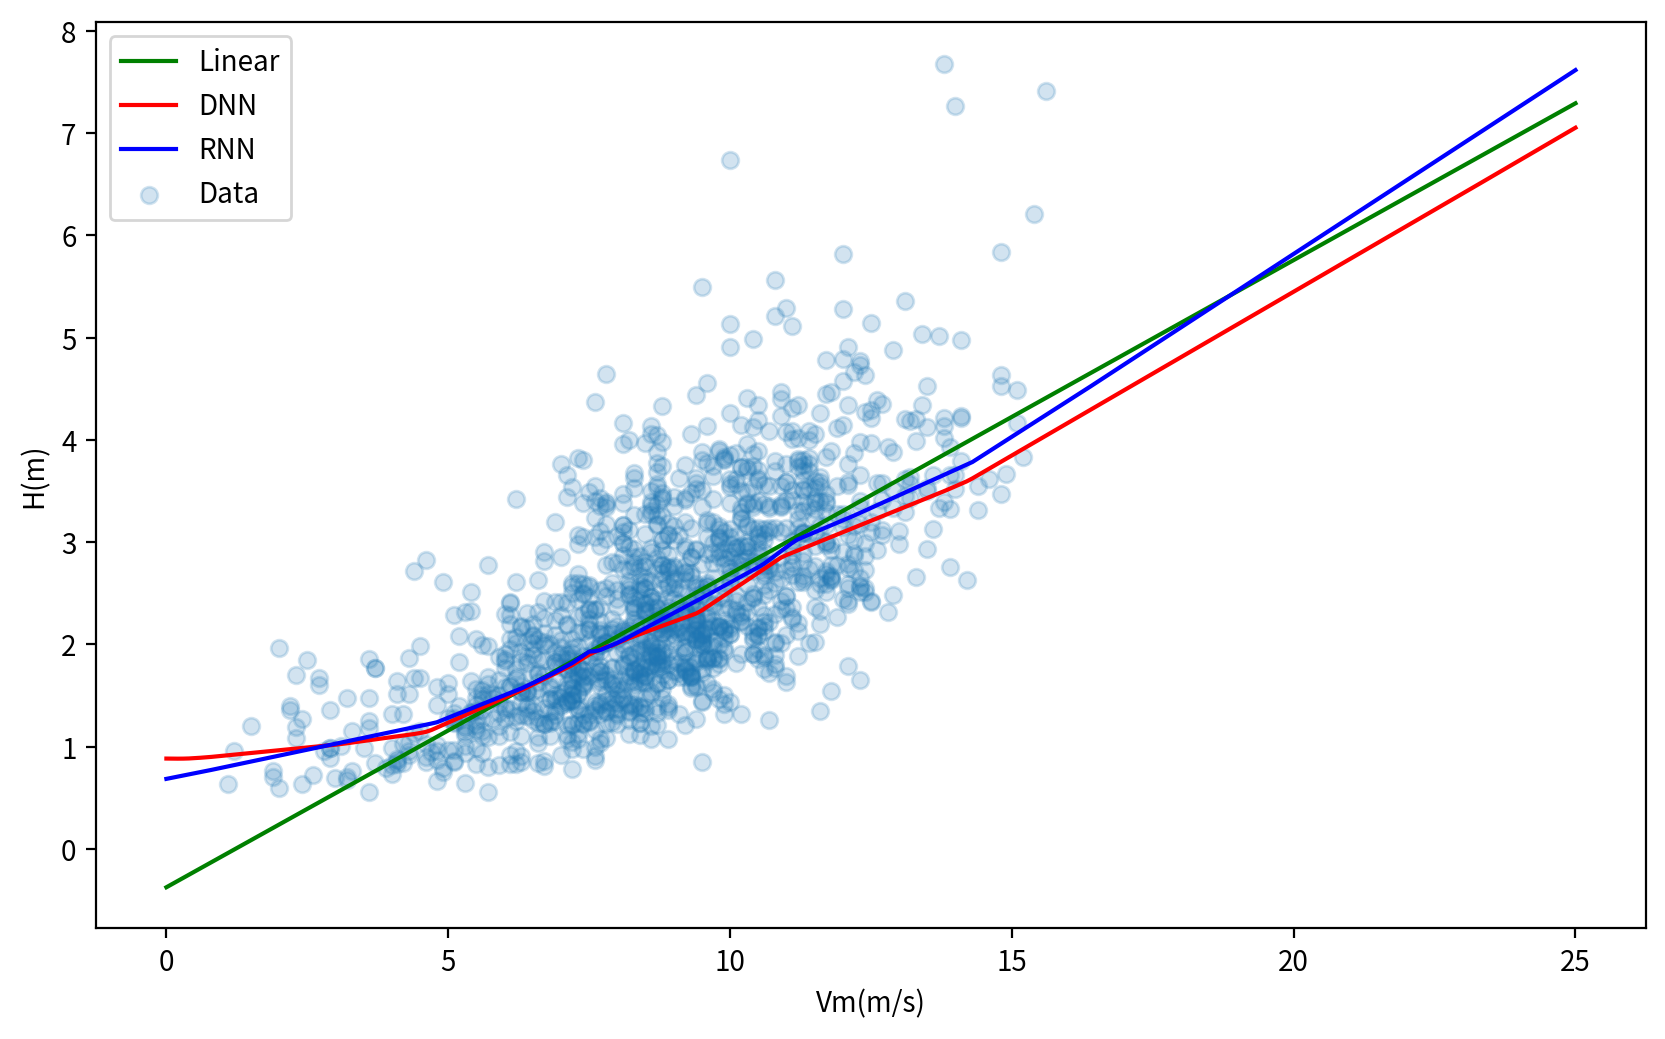

In [75]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
y1 = rnn_Vm_model.predict(x)
y2 = dnn_Vm_model.predict(x)
y4 = Vm_model.predict(x)

plt.scatter(train_features['Vm'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
#plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.plot(x, y1, color='b', label='RNN')
plt.xlabel('Vm(m/s)')
plt.ylabel('H(m)')
plt.legend()

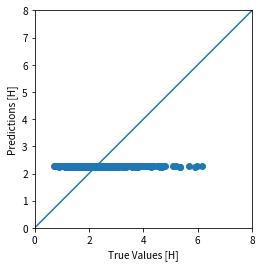

In [76]:
test_predictions = rnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


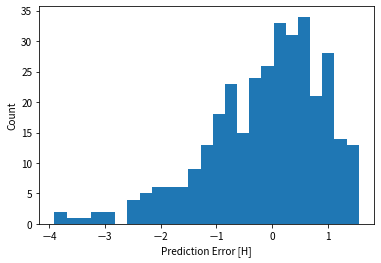

In [77]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')

In [78]:
rnn_model.save(   'saved_model/Vm_H_rnn_model_DJF')
rnn_Vm_model.save('saved_model/Vm_H_rnn_Vm_model_DJF')

INFO:tensorflow:Assets written to: saved_model/Vm_H_rnn_model_DJF/assets
INFO:tensorflow:Assets written to: saved_model/Vm_H_rnn_Vm_model_DJF/assets


## SVM

In [79]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [80]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [81]:
history = svr.fit(np.array(train_features['Vm']).reshape(-1,1), train_labels)

In [82]:
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    np.array(test_features['Vm']).reshape(-1,1),
    test_labels,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_absolute_error",
    cv=10,
)

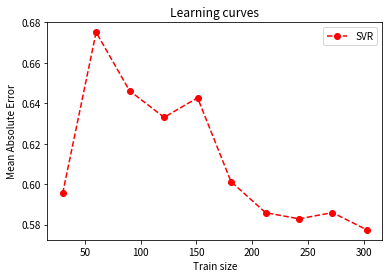

In [83]:
#plt.plot(train_sizes, -test_scores_kr.mean(1), "o--", color="g", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), "o--", color="r", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning curves")
plt.legend(loc="best")

In [84]:
-test_scores_svr.mean(1)

array([0.595, 0.675, 0.646, 0.633, 0.643, 0.601, 0.586, 0.583, 0.586,
       0.577])

In [85]:
svr.predict(np.array(train_features['Vm']).reshape(-1,1))

array([2.086, 3.394, 2.53 , ..., 2.369, 2.885, 3.394])

In [86]:
import joblib
joblib.dump(svr, 'saved_model/Vm_H_svr_Vm_model_DJF')

['saved_model/Vm_H_svr_Vm_model_DJF']

In [87]:
svr2 = joblib.load("saved_model/Vm_H_svr_Vm_model_DJF")

In [88]:
svr2.predict(np.array(train_features['Vm']).reshape(-1,1))

array([2.086, 3.394, 2.53 , ..., 2.369, 2.885, 3.394])

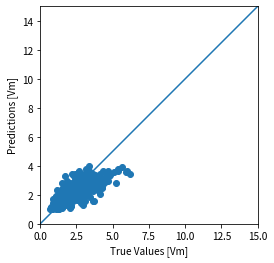

In [89]:
test_predictions = svr2.predict(np.asarray(test_features['Vm'])[:,None]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vm]')
plt.ylabel('Predictions [Vm]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

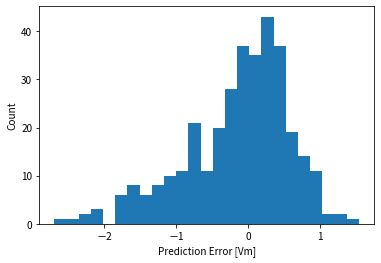

In [90]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vm]')
_ = plt.ylabel('Count')

## Multi-variable

In [91]:
history = svr.fit(np.array(train_features), train_labels)

In [92]:
train_sizes_mv, train_scores_svr_mv, test_scores_svr_mv = learning_curve(
    svr,
    np.array(test_features),
    test_labels,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_absolute_error",
    cv=10,
)

In [93]:
import joblib
joblib.dump(svr, 'saved_model/Vm_H_svr_model_DJF')

['saved_model/Vm_H_svr_model_DJF']

In [94]:
svr = joblib.load("saved_model/Vm_H_svr_model_DJF")

In [95]:
svr.predict(np.array(train_features))

array([2.151, 4.315, 2.78 , ..., 2.13 , 2.878, 2.51 ])

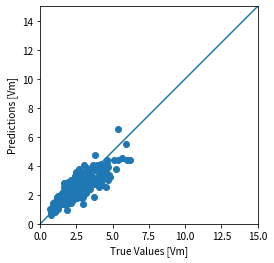

In [96]:
test_predictions = svr.predict(np.asarray(test_features)).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vm]')
plt.ylabel('Predictions [Vm]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

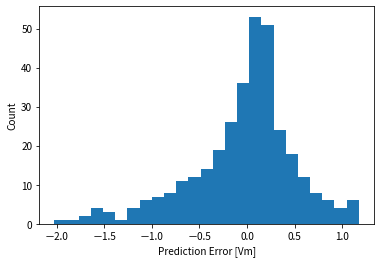

In [97]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vm]')
_ = plt.ylabel('Count')

In [98]:
def svr_evaluate(test_features, test_labels):
    return np.mean(np.abs(test_features-test_labels))

In [99]:
svr_evaluate(svr.predict(np.array(test_features)),np.array(test_labels))

0.39800234851478256

In [100]:
np.abs(svr.predict(np.array(test_features))-np.array(test_labels))

array([0.478, 0.082, 0.515, 0.557, 0.361, 0.222, 0.324, 0.063, 0.162,
       0.04 , 0.214, 0.048, 0.152, 0.149, 0.948, 0.093, 0.079, 0.301,
       0.225, 0.984, 0.774, 1.613, 0.681, 0.246, 0.035, 0.667, 0.077,
       0.006, 0.305, 0.393, 0.144, 0.038, 0.006, 0.032, 0.035, 0.564,
       1.127, 0.308, 0.185, 0.367, 1.083, 0.112, 0.573, 0.028, 0.55 ,
       0.736, 0.214, 0.249, 0.026, 0.25 , 0.036, 0.104, 0.233, 0.275,
       0.396, 0.197, 0.201, 1.064, 0.703, 0.195, 1.406, 1.764, 1.56 ,
       0.162, 0.394, 0.319, 2.023, 0.852, 0.688, 0.542, 0.947, 0.166,
       0.293, 0.148, 0.138, 0.084, 0.247, 0.246, 0.115, 0.194, 0.243,
       0.417, 0.588, 1.132, 0.236, 0.276, 0.156, 0.676, 1.65 , 0.407,
       0.396, 0.608, 0.606, 0.52 , 0.52 , 0.132, 0.773, 0.709, 1.059,
       0.398, 1.412, 0.074, 0.486, 0.724, 0.264, 0.621, 0.075, 0.285,
       0.028, 0.164, 0.727, 0.016, 0.903, 1.101, 0.126, 0.428, 0.318,
       0.177, 0.662, 1.255, 0.056, 0.177, 0.201, 0.211, 0.658, 0.365,
       0.96 , 0.214,